<a href="https://colab.research.google.com/github/Ojas6987/LoanPrediction/blob/main/LoanPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [3]:
train = pd.read_csv('train.csv')

train

train = train.drop(columns = ['Loan_ID'])
train['Loan_Status'] = train['Loan_Status'].apply(lambda x: 1.0 if x == 'Y' else 0.0)
train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1.0
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0.0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1.0
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1.0
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,1.0
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,1.0
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,1.0
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,1.0


**Initial EDA. Explored the dataset as a whole, as well as feature exploration**

In [4]:
train.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status          float64
dtype: object

In [5]:
train.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
train['Loan_Status'].value_counts()

Loan_Status
1.0    422
0.0    192
Name: count, dtype: int64

**Below are some pairplots for each feature. The plots show primarily the complex nature of the data, given that clear categories or "clusters" aren't seen from the plots. There seem to be some relationships between features, such as LoanAmount and ApplicationIncome, but overall no singular feature seems to be highly correlated with the other. Overall, it seems that a simple model such as logistic regression likely won't be useful here**

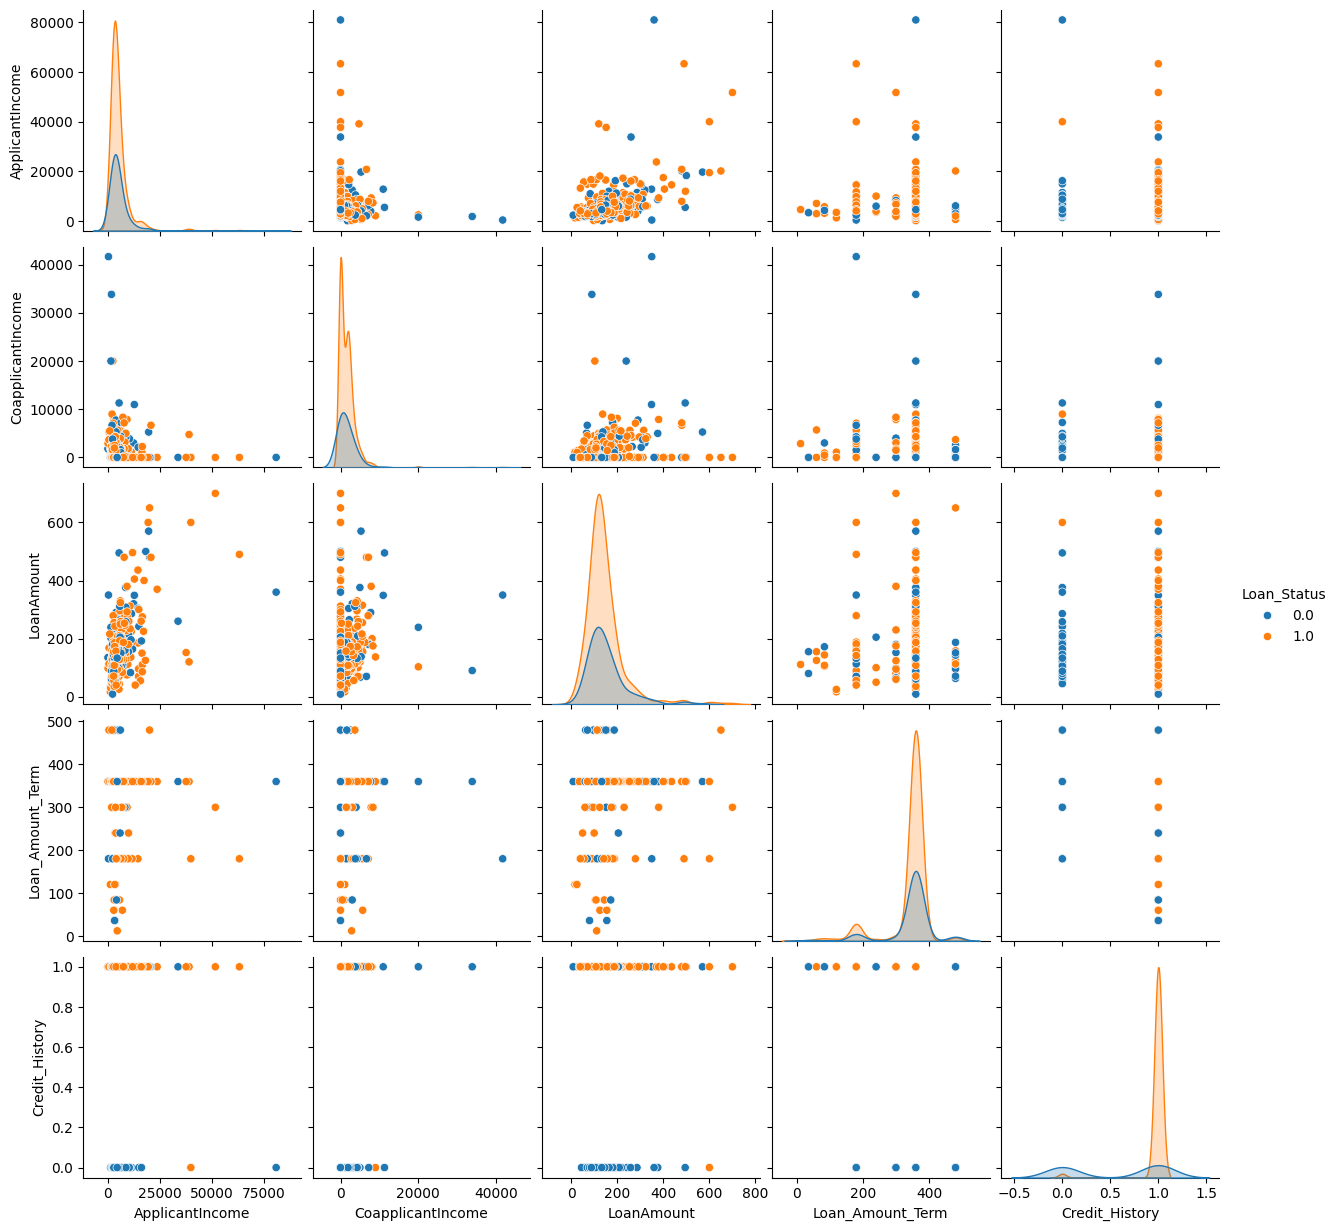

In [43]:
import seaborn as sns
sns.pairplot(train, hue = 'Loan_Status')

In [44]:
quant = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
train[quant].corr()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
ApplicantIncome,1.000000,-0.116605,0.570909,-0.045306
CoapplicantIncome,-0.116605,1.000000,0.188619,-0.059878
LoanAmount,0.570909,0.188619,1.000000,0.039447
Loan_Amount_Term,-0.045306,-0.059878,0.039447,1.000000


**None of the quantatitive features seem to be highly correlated with each other**

**Data Cleaning/Preprocessing**

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder, StandardScaler

X = train.drop(columns = 'Loan_Status')
y = train['Loan_Status']



cat = X.drop(columns = quant).columns

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),

    ('onehot', OneHotEncoder(handle_unknown = 'ignore', drop = 'first'))
])

quant_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('std', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('quant', quant_transformer, quant),
        ('cat', cat_transformer, cat)

    ])

new_train = preprocessor.fit_transform(X)
new_train

array([[ 0.07299082, -0.55448733, -0.30275919, ...,  1.        ,
         0.        ,  1.        ],
       [-0.13441195, -0.03873155, -0.20764834, ...,  1.        ,
         0.        ,  0.        ],
       [-0.39374734, -0.55448733, -0.94475737, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 0.43717437, -0.47240418,  1.27845856, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.35706382, -0.55448733,  0.49379411, ...,  1.        ,
         0.        ,  1.        ],
       [-0.13441195, -0.55448733, -0.14820407, ...,  0.        ,
         1.        ,  0.        ]])

In [46]:

onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat)


feature_names = quant + list(onehot_feature_names)


train_proc = pd.DataFrame(new_train, columns=feature_names)

train_proc


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Credit_History_1.0,Property_Area_Semiurban,Property_Area_Urban
0,0.072991,-0.554487,-0.302759,0.273231,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.134412,-0.038732,-0.207648,0.273231,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.393747,-0.554487,-0.944757,0.273231,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,-0.462062,0.251980,-0.302759,0.273231,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.097728,-0.554487,-0.053093,0.273231,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,-0.410130,-0.554487,-0.885313,0.273231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
610,-0.212557,-0.554487,-1.253868,-2.522836,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
611,0.437174,-0.472404,1.278459,0.273231,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
612,0.357064,-0.554487,0.493794,0.273231,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


**Due to the messy nature of the data, my initial model is a KNN classifier as there doesn't seem to be any linear boundaries for predictions. For each model I further checked the cross-validation score to see how the model performed on unseen data**

In [50]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_proc, y)

acc = neigh.score(train_proc, y)

from sklearn.metrics import precision_score, recall_score

yhat = neigh.predict(train_proc)

precision = precision_score(y, yhat)
recall = recall_score(y, yhat)

precision, recall, acc

(0.8562367864693446, 0.9597156398104265, 0.8615635179153095)

**While the training accuraccy is solid, with good precision and recall as well signifying no serious class imbalance, the overall cross-validation score is lower at 72, signifying that this model isn't performing as well on new data**

In [52]:
cv_scores = cross_val_score(neigh, train_proc, y, cv=50)


cv_scores.mean()

0.7291025641025642

**Next, I tried a decision tree classifier to better capture the complexities of the datasets**

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier()

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(tree, param_grid, cv=10, scoring='accuracy')

grid_search.fit(train_proc, y)

# Get the best hyperparameters
grid_search.best_params_



{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [60]:
tree = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2)
tree.fit(train_proc, y)
yhat = tree.predict(train_proc)

acc = tree.score(train_proc, y)
precision = precision_score(y, yhat)
recall = recall_score(y, yhat)

precision, recall, acc


(0.8978260869565218, 0.9786729857819905, 0.9087947882736156)

**While the decision tree has a higher training accuracy than the KNN, it also seems to perform worse on unseen data. Therefore, for my next model I moved on to a random forest classifier to account for possible overfitting**

In [61]:
cv_scores = cross_val_score(tree, train_proc, y, cv=50)


cv_scores.mean()

0.7192307692307693

In [63]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10]
}


forest = RandomForestClassifier()


grid_search = GridSearchCV(forest, param_grid, cv=10, scoring='accuracy')


grid_search.fit(train_proc, y)


best_params = grid_search.best_params_

best_params


{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}

In [64]:
forest = RandomForestClassifier(max_depth = 10, min_samples_split = 10, n_estimators = 50)

forest.fit(train_proc, y)

yhat= forest.predict(train_proc)
acc = forest.score(train_proc, y)

precision = precision_score(y, yhat)
recall = recall_score(y, yhat)

precision, recall, acc

(0.8185404339250493, 0.9834123222748815, 0.8387622149837134)

**The forest classifier has a higher cv score than the tree despite lower training error, showing that this model seems to be performing well on unseen data**

In [65]:
cv_scores = cross_val_score(forest, train_proc, y, cv=50)


cv_scores.mean()

0.8078205128205128

**I further tried an XGBoost model as an ensemble model to see if I could get any better results**

In [67]:
import xgboost as xgb

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_clf = xgb.XGBClassifier()


grid_search = GridSearchCV(xgb_clf, param_grid, cv=10, scoring='accuracy')


grid_search.fit(train_proc, y)

grid_search.best_params_


{'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50, 'subsample': 0.8}

In [68]:
xgb_clf = xgb.XGBClassifier(learning_rate = 0.01, max_depth = 1, n_estimators = 50, subsample = 0.8)

xgb_clf.fit(train_proc, y)
yhat = xgb_clf.predict(train_proc)

xgb_clf.score(train_proc, y)

0.8094462540716613

**Overall, the XGBoost model seems to have a similar cross-validation score to the random forest classifier**

In [70]:

cv_scores = cross_val_score(xgb_clf, train_proc, y, cv=100)


cv_scores.mean()


0.8085714285714286

**Finally, I attempted to use a Sequential Feature Selector to see if there was a subset of features that dramatically improved performance. However, cross-validation performance stayed around the same**

In [36]:
from mlxtend.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(estimator=forest, k_features=(1,14), forward=True, scoring='accuracy', cv=5)

sfs.fit(train_proc, y)

list(sfs.k_feature_idx_)





[0, 1, 4, 5, 6, 7, 9, 10, 11, 12]

In [40]:
selected_features = train_proc.columns[list(sfs.k_feature_idx_)]
print("Selected features:", selected_features)

new_forest = RandomForestClassifier(max_depth = 10, min_samples_split = 10, n_estimators = 50)

new_forest.fit(train_proc[selected_features], y)

yhat= new_forest.predict(train_proc[selected_features])
acc = new_forest.score(train_proc[selected_features], y)

precision = precision_score(y, yhat)
recall = recall_score(y, yhat)

precision, recall, acc



Selected features: Index(['ApplicantIncome', 'CoapplicantIncome', 'Gender_Male', 'Married_Yes',
       'Dependents_1', 'Dependents_2', 'Education_Not Graduate',
       'Self_Employed_Yes', 'Credit_History_1.0', 'Property_Area_Semiurban'],
      dtype='object')


(0.832, 0.985781990521327, 0.8534201954397395)

In [42]:
cv_scores = cross_val_score(new_forest, train_proc, y, cv=100)


cv_scores.mean()

0.8019047619047619

In [ ]:
test = pd.read_csv('test.csv')



preprocessor2 = ColumnTransformer(
    transformers=[
        ('quant', quant_transformer, quant),
        ('cat', cat_transformer, cat)

    ])



new_test = preprocessor2.fit_transform(test.drop(columns = 'Loan_ID'))

new_test

array([[ 0.1864605 , -0.67333511, -0.43232129, ...,  0.        ,
         0.        ,  1.        ],
       [-0.35269225, -0.02984821, -0.16952723, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.0396413 ,  0.09884917,  1.17729232, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.31721094,  0.18164449, -0.16952723, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.0396413 ,  0.353241  ,  0.35606089, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.89608667, -0.67333511, -0.62941683, ...,  1.        ,
         0.        ,  0.        ]])

In [ ]:
onehot_feature_names2 = preprocessor2.named_transformers_['cat']['onehot'].get_feature_names_out(cat)


feature_names2 = quant + list(onehot_feature_names2)


test_proc = pd.DataFrame(new_test, columns=feature_names2)

yhat_test = forest.predict(test_proc)
yhat_test



array([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1.

In [ ]:
solution = pd.DataFrame([test['Loan_ID'], yhat_test]).T
solution.columns = ['Loan_ID', 'Loan_Status']
solution['Loan_Status'] = solution['Loan_Status'].apply(lambda x: 'Y' if x == 1.0 else 'N')
solution

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y
...,...,...
362,LP002971,Y
363,LP002975,Y
364,LP002980,Y
365,LP002986,Y


In [ ]:
solution.to_csv('solution.csv', index=False)

In [ ]:
print('hello world')

hello world
